In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer


df = pd.read_csv("heart_disease_uci.csv")

# перевірка данних
df.head() 

#df.info()
#df.describe()



,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


array([[<Axes: title={'center': 'id'}>, <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'trestbps'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'thalch'}>,
        <Axes: title={'center': 'oldpeak'}>],
       [<Axes: title={'center': 'ca'}>, <Axes: title={'center': 'num'}>,
        <Axes: >]], dtype=object)

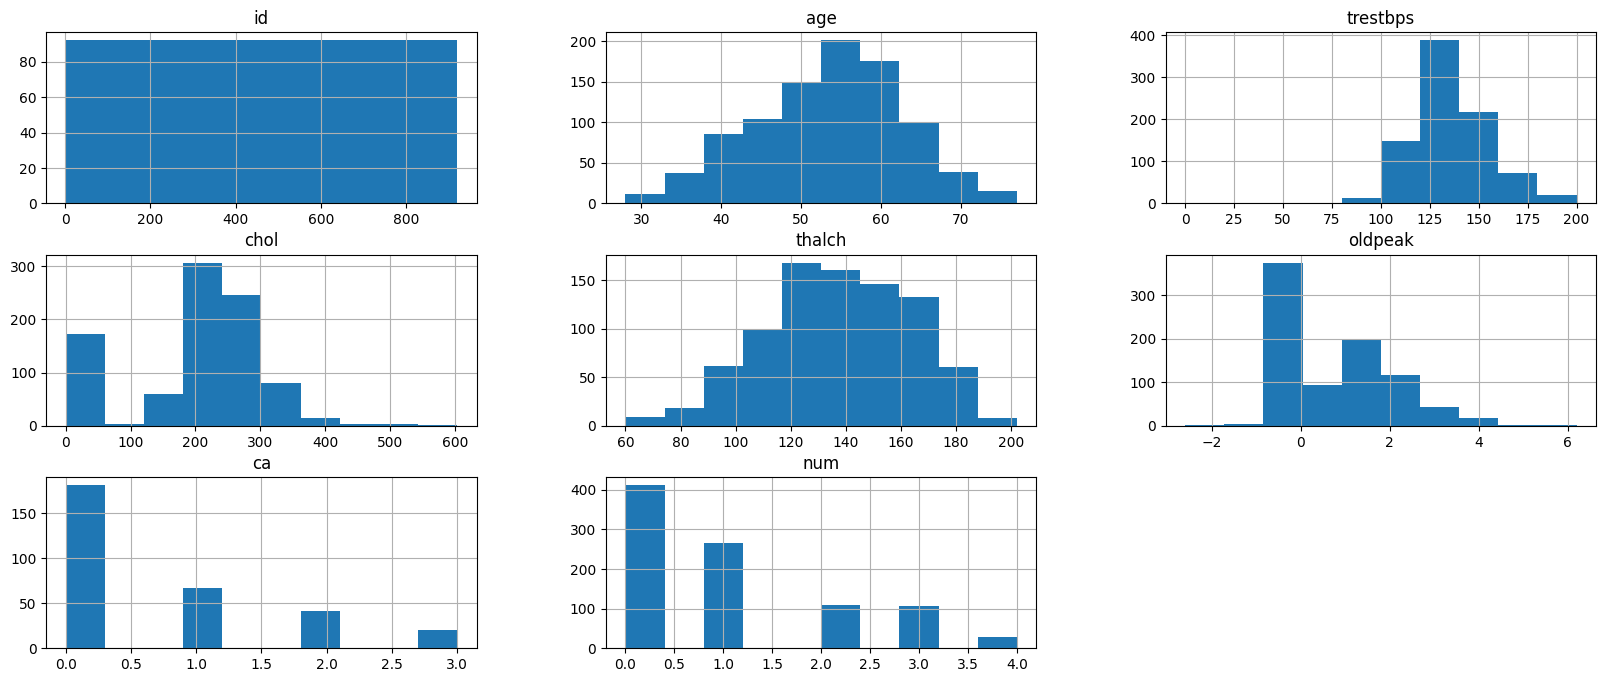

In [22]:
df.hist(figsize=(20, 8)) # create histograms of columns

In [23]:
# перевірка на пропуски

print("Size of dataset:", df.shape) # rows and columns
print("\nIs Null")
missing_data = df.isna().sum()
print(missing_data, "\n")

print("\nIs 0")
zero_data = (df == 0).sum()
print(zero_data)


Size of dataset: (920, 16)

Is Null
id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64 


Is 0
id            0
age           0
sex           0
dataset       0
cp            0
trestbps      1
chol        172
fbs         692
restecg       0
thalch        0
exang       528
oldpeak     370
slope         0
ca          181
thal          0
num         411
dtype: int64


In [26]:
df_cleaned = df.copy()

# Замінити 0 на Null у вказаних колонках
columns_to_replace_zero = ['trestbps', 'chol', 'restecg', 'thalch', 'oldpeak']
for col in columns_to_replace_zero:
    df_cleaned.loc[df_cleaned[col] == 0, col] = pd.NA

# Замінити всі негативні значення на Null в колонці oldpeak
df_cleaned.loc[df_cleaned['oldpeak'] < 0, 'oldpeak'] = pd.NA

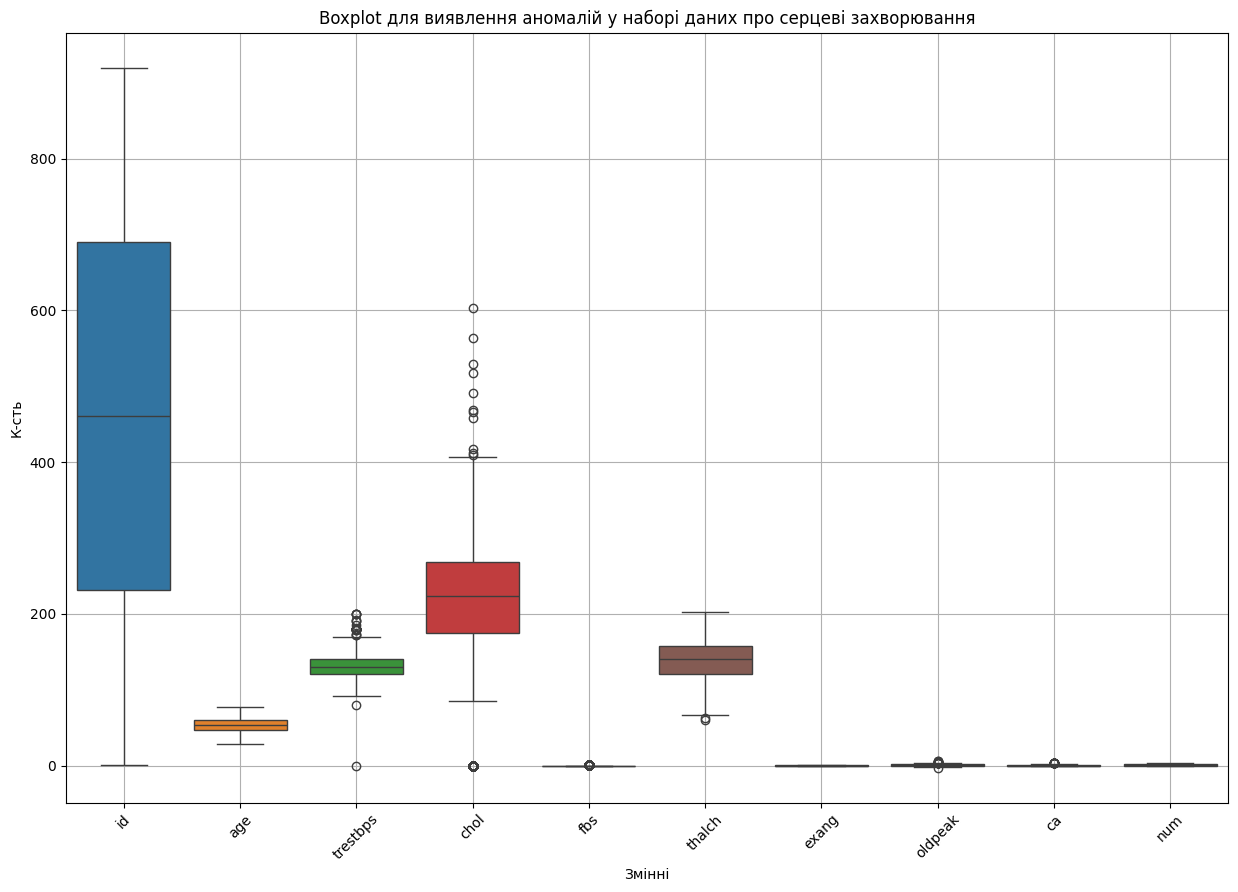

In [25]:
# виявлення аномалій

plt.figure(figsize=(15, 10)) # збільшення розміру графіка
sns.boxplot(data=df)
plt.title("Boxplot для виявлення аномалій у наборі даних про серцеві захворювання")
plt.xlabel("Змінні")
plt.ylabel("К-сть")
plt.xticks(rotation=45) # повертаємо на 45 градусів для кращої читабельності
plt.grid(True) # сітка
plt.show()

In [27]:
def detect_outliers(data, col, trheshold=3):
    mean = data[col].mean()
    std = data[col].std()
    
    up_bound = mean + trheshold * std
    low_bound = mean - trheshold * std
    
    anomalies = pd.concat([data[col] > up_bound, data[col] < low_bound], axis=1).any(axis=1) # значенння true вказують на аномалію
    return anomalies, up_bound, low_bound

outlier_results = {} # буде містити резльтати аналізу аномалій кожного стовпця


numeric_columns = df.select_dtypes(include=['number'])

for col in numeric_columns.columns:
    anomalies, upper_bound, lower_bound = detect_outliers(df, col)
    outlier_results[col] = {
        "anomalies": anomalies,
        "upper_bound": upper_bound,
        "lower_bound": lower_bound
    }
    
    # Виведення результатів для кожного стовпця
    print(f"Column: {col}")
    print(f"Upper bound: {upper_bound}")
    print(f"Lower bound: {lower_bound}")
    print(f"Anomalies: {anomalies.sum()}") # Кількість аномалій
    print(anomalies[anomalies].index) # Індекси аномалій
    print()  # Додатковий рядок для візуального розділення результатів

Column: id
Upper bound: 1257.6762665809865
Lower bound: -336.6762665809865
Anomalies: 0
Index([], dtype='int64')

Column: age
Upper bound: 81.78492519394797
Lower bound: 25.23681393648682
Anomalies: 0
Index([], dtype='int64')

Column: trestbps
Upper bound: 189.3306127369471
Lower bound: 74.93419562542226
Anomalies: 8
Index([126, 188, 338, 548, 680, 701, 753, 896], dtype='int64')

Column: chol
Upper bound: 531.4727681383432
Lower bound: -133.21209398103986
Anomalies: 2
Index([152, 546], dtype='int64')

Column: thalch
Upper bound: 215.32449421827715
Lower bound: 59.76683526149161
Anomalies: 0
Index([], dtype='int64')

Column: oldpeak
Upper bound: 4.152466623827468
Lower bound: -2.3948908662517105
Anomalies: 7
Index([91, 123, 183, 191, 285, 589, 615], dtype='int64')

Column: ca
Upper bound: 3.483334442210705
Lower bound: -2.1305836331492167
Anomalies: 0
Index([], dtype='int64')

Column: num
Upper bound: 4.423732383927154
Lower bound: -2.432428036101067
Anomalies: 0
Index([], dtype='int64'

In [28]:
def replace_anomalies(data, col, threshold=3):
    anomalies, _, _ = detect_outliers(data, col, threshold)
    # Заміна аномалій на NaN (Null)
    data.loc[anomalies, col] = pd.NA
    # Повернення зміненого DataFrame
    return data

# Заміна аномалій для кожного числового стовпця
for col in numeric_columns.columns:
    df_cleaned = replace_anomalies(df_cleaned, col)

# Після заміни аномалій, знову перевірте наявність аномалій
for col in numeric_columns.columns:
    anomalies, upper_bound, lower_bound = detect_outliers(df_cleaned, col)
    
    print(f"Column: {col}")
    print(f"Upper bound: {upper_bound}")
    print(f"Lower bound: {lower_bound}")
    print(f"Anomalies: {anomalies.sum()}") # Кількість аномалій
    print(anomalies[anomalies].index) # Індекси аномалій
    print()  # Додатковий рядок для візуального розділення результатів

Column: id
Upper bound: 1257.6762665809865
Lower bound: -336.6762665809865
Anomalies: 0
Index([], dtype='int64')

Column: age
Upper bound: 81.78492519394797
Lower bound: 25.23681393648682
Anomalies: 0
Index([], dtype='int64')

Column: trestbps
Upper bound: 184.80537539658687
Lower bound: 78.72100209462062
Anomalies: 1
Index([700], dtype='int64')

Column: chol
Upper bound: 397.8283241607504
Lower bound: 89.85899978291158
Anomalies: 6
Index([48, 121, 181, 373, 473, 566], dtype='int64')

Column: thalch
Upper bound: 215.32449421827715
Lower bound: 59.76683526149161
Anomalies: 0
Index([], dtype='int64')

Column: oldpeak
Upper bound: 4.279789686817894
Lower bound: -1.108965162504997
Anomalies: 1
Index([285], dtype='int64')

Column: ca
Upper bound: 3.483334442210705
Lower bound: -2.1305836331492167
Anomalies: 0
Index([], dtype='int64')

Column: num
Upper bound: 4.423732383927154
Lower bound: -2.432428036101067
Anomalies: 0
Index([], dtype='int64')



In [29]:
numeric_data = df_cleaned.select_dtypes(include=['number'])

# Обчислення кореляції між числовими стовпцями
corr = numeric_data.corr()

corr.style.background_gradient(cmap='coolwarm')

,id,age,trestbps,chol,thalch,oldpeak,ca,num
id,1.000000,0.239301,0.061313,-0.030420,-0.466427,0.119288,0.061433,0.273552
age,0.239301,1.000000,0.258535,0.110978,-0.365778,0.093936,0.370416,0.339596
trestbps,0.061313,0.258535,1.000000,0.125316,-0.103192,0.130462,0.075585,0.117844
chol,-0.030420,0.110978,0.125316,1.000000,-0.026746,0.029240,0.151809,0.087772
thalch,-0.466427,-0.365778,-0.103192,-0.026746,1.000000,-0.101676,-0.264094,-0.366265
oldpeak,0.119288,0.093936,0.130462,0.029240,-0.101676,1.000000,0.246564,0.386199
ca,0.061433,0.370416,0.075585,0.151809,-0.264094,0.246564,1.000000,0.516216
num,0.273552,0.339596,0.117844,0.087772,-0.366265,0.386199,0.516216,1.000000


                                id       age  trestbps      chol    thalch  \
id                        1.000000  0.239301  0.052924 -0.376936 -0.466427   
age                       0.239301  1.000000  0.244253 -0.086234 -0.365778   
trestbps                  0.052924  0.244253  1.000000  0.092853 -0.104899   
chol                     -0.376936 -0.086234  0.092853  1.000000  0.236121   
thalch                   -0.466427 -0.365778 -0.104899  0.236121  1.000000   
oldpeak                   0.049930  0.258243  0.161908  0.047734 -0.151174   
ca                        0.061433  0.370416  0.093705  0.051606 -0.264094   
num                       0.273552  0.339596  0.122291 -0.231547 -0.366265   
sex_Female               -0.280053 -0.056889 -0.001087  0.197281  0.179320   
sex_Male                  0.280053  0.056889  0.001087 -0.197281 -0.179320   
dataset_Cleveland        -0.814705  0.062729 -0.017377  0.306956  0.345974   
dataset_Hungary          -0.024453 -0.407613  0.017296  0.310879

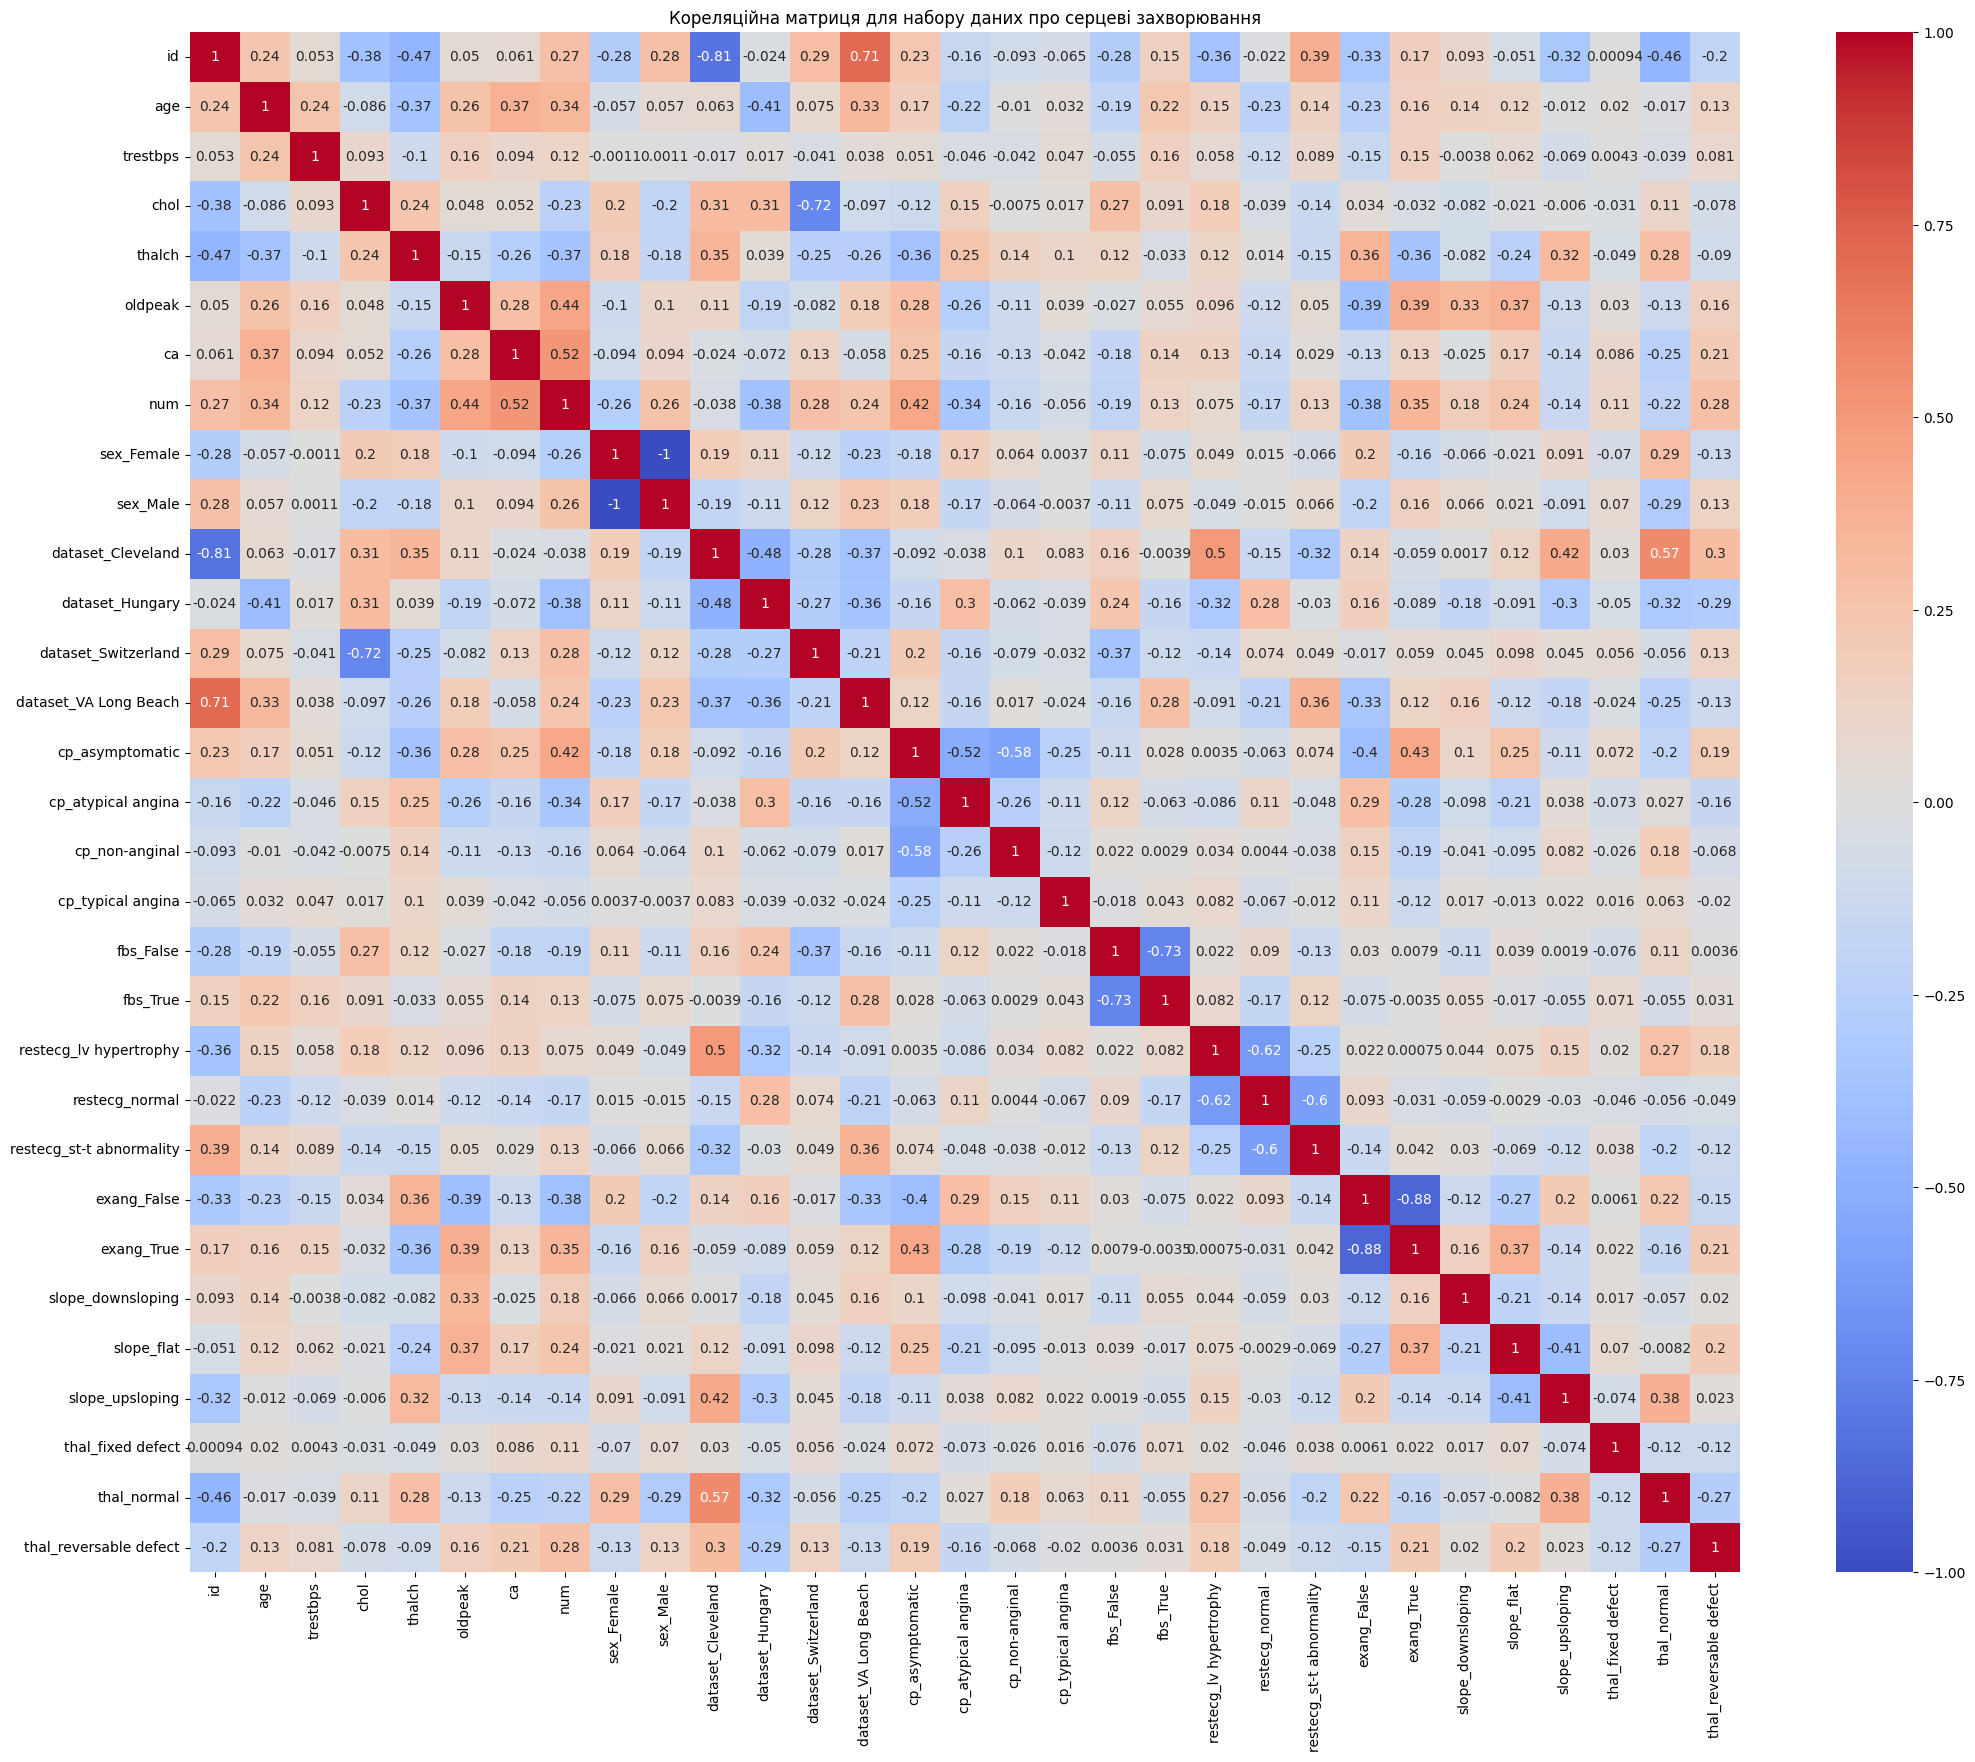

In [30]:
# Кореляційна матриця

import seaborn as sns
import matplotlib.pyplot as plt

# Перетворення категоріальних змінних у числові ( Наприклад - Жінка/Чоловік змінити на 0/1 )
df_numeric = pd.get_dummies(df)

# Побудова кореляційної матриці
correlation_matrix = df_numeric.corr()

# Виведення кореляційної матриці
print(correlation_matrix)

# Візуалізація кореляційної матриці
plt.figure(figsize=(25, 20))  # Збільшуємо розмір графіку
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm') # annot=True - над кожни блоком буде показано числове значення
# cmap='coolwarm' - з холодних до теплих кольорів
plt.title('Кореляційна матриця для набору даних про серцеві захворювання')
plt.show()



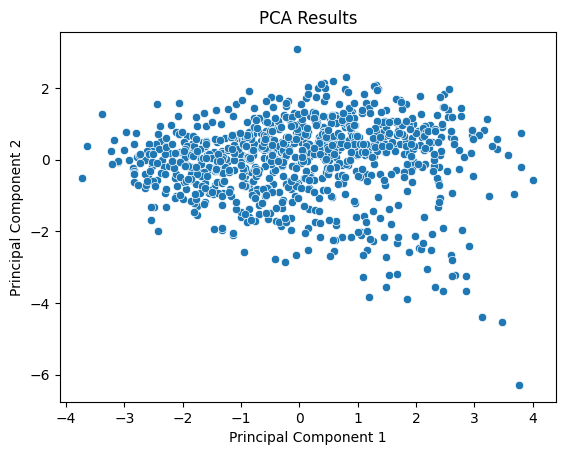

In [32]:
imputer = SimpleImputer(strategy='mean')  
filled_data = imputer.fit_transform(numeric_data)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(filled_data)

pca = PCA(n_components=2)

pca_result = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

sns.scatterplot(x='PC1', y='PC2', data=pca_df)

plt.title('PCA Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()